# The random phase approximation (RPA)


The bare susceptibility $\chi_0$ is the exact linear response in the non-interacting limit. For interacting systems the susceptibility $\chi$ is given by the Bethe-Salpeter equation

$$ \chi = \chi_0 + \chi_0 \Gamma \chi \, ,$$

where $\Gamma$ is an irreducible vertex function, containing all diagrams with insertions of the interaction that can not be separated by cutting a pair of (particle-hole) single-particle propagators $G G$. The first order contribution to the vertex $\Gamma$ is the bare interaction $U$ and the approximation

$$ \Gamma = U/2 \, $$

gives the so-called random phase approximation (RPA) for $\chi$, i.e.

$$ \chi_{RPA} = \chi_0 + \chi_0 \frac{U}{2} \chi_{RPA} \, , $$

and solving for $\chi_{RPA}$ gives

$$ \chi_{RPA} = \frac{\chi_0}{1 - \frac{U}{2} \chi_0} \, . $$

Note that the denominator of this equation can go to zero, whereby the susceptibility $\chi_{RPA}$ diverges. This behaviour is a signature of an instability of the system towards symmetry breaking, like anti-ferromagnetism or charge order.

As an example we compute $\chi_{RPA}$ for the square lattice with local Hubbard interaction, and study the enhancement of the $\mathbf{q} = (\pi, \pi)$ peak as a function of the Hubbard interaction $U$.

RPA predicts a phase transition to an antiferromagnetic state at *finite temperatures*. In two dimensions this is unphysical since the Mermin Wagner theorem constrains the phase transition to occur only at zero temperature. 

We will later see how to remedy this shortcoming of RPA using the two-particle self consistent approach (TPSC).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from triqs.plot.mpl_interface import plt, oplot

import numpy as np
from triqs.gf import *

## RPA solver

In general the RPA equation is a tensor equation in the four indices of the two-particle susceptibility. However, in our simple example the RPA equation is scalar valued and we account for spin by extra factors of 2 and 1/2 in the formulas.

The RPA solver in TPRF `triqs_tprf.lattice.solve_rpa_PH` is designed to handle the general rank four case and can be readily used for multi orbital problems. Here we will apply it to the scalar case. Here is an example that computes $\chi_{RPA}$:

```python
from triqs_tprf.lattice import solve_rpa_PH
I = np.ones([1, 1, 1, 1], dtype=complex) # One element rank 4 tensor to comply with the general implementation
chi_wk = solve_rpa_PH(chi0_wk, U/2 * I)
```



### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1 

Read `chi0_wk` from disk and use it to calculate $\chi_{RPA}$ for $U = 2.7$ and call the result `chi_wk`.

Plot `chi_wk` for zero frequency in the entire Brillouin zone, and compare the result with the plot for `chi0_wk` in the previous notebook.

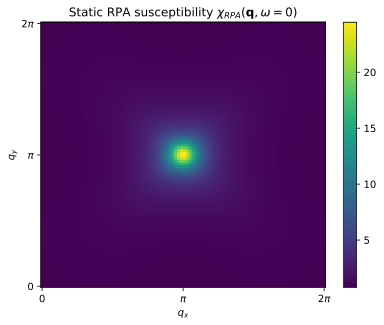

In [2]:
# Write your code here

from h5 import HDFArchive

with HDFArchive("chi0_wk.h5",'r') as R:
    chi0_wk = R['chi0_wk']

U = 2.7

from triqs_tprf.lattice import solve_rpa_PH
I = np.ones([1, 1, 1, 1], dtype=complex)
chi_wk = solve_rpa_PH(chi0_wk, U/2 * I)

k = np.linspace(0, 2*np.pi, 100, endpoint=True)
kx, ky = np.meshgrid(k, k)

chi_k_interp = np.vectorize(lambda qx, qy: chi_wk(0,(qx, qy, 0)).real)

plt.pcolor(kx, ky, chi_k_interp(kx, ky), rasterized=True)

plt.title('Static RPA susceptibility $\chi_{RPA}(\mathbf{q}, \omega=0)$')
ticks, labels = [0, np.pi, 2*np.pi], [r"0",r"$\pi$",r"$2\pi$"]
plt.xticks(ticks, labels); plt.yticks(ticks, labels);
plt.xlabel(r'$q_x$'); plt.ylabel(r'$q_y$')
plt.colorbar();

**Questions**

- What is the difference in magnitude of the response at $\mathbf{Q}=(\pi, \pi)$ between $\chi_{RPA}$ and $\chi_0$?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2

To see how the incommensurate response changes with the interaction $U$ plot $\chi_{RPA}$ along the high symmetry path $\Gamma \rightarrow X \rightarrow M \rightarrow \Gamma$ for a few values of $U = 0, 1, 2$. Use the visualization code from the previous notebook as a starting point.

Starting serial run at: 2023-08-29 11:09:11.701127


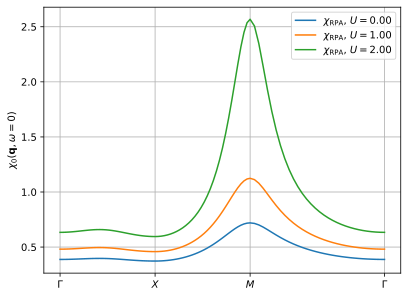

In [3]:
# Write your code here

G = [0.0, 0.0, 0.0]
X = [0.5, 0.0, 0.0]
M = [0.5, 0.5, 0.0]

path = [(G, X), (X, M), (M, G)]

from triqs_tprf.lattice_utils import k_space_path

k_vecs, k_plot, k_ticks = k_space_path(path, num=32, bz=chi0_wk.mesh[1].bz)
    
for U in [0., 1., 2.]:
    chi_wk = solve_rpa_PH(chi0_wk, U/2 * I)
    chi_k_interp = np.vectorize(lambda k : chi_wk(0, k).real, signature='(n)->()')
    plt.plot(k_plot, chi_k_interp(k_vecs), label=r'$\chi_\mathrm{RPA}$, $U=%2.2f$' % U)
    
plt.xticks(k_ticks, labels=[r'$\Gamma$', '$X$', '$M$', r'$\Gamma$'])
plt.ylabel(r'$\chi_0(\mathbf{q},\omega=0)$'); plt.grid(); plt.legend();

**Questions**

- How does the static RPA susceptibility change with $U$?
- Is the amplitude change even across the Brillouin zone?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 3:  Critical $U$

At some critical value of the interaction $U = U_c$ the RPA susceptibility diverges

$$\chi_{RPA} \rightarrow \infty \, .$$

To determine $U_c$ we can study the root of the inverse susceptibility $\chi_{RPA}^{-1}$.

For the square lattice it is sufficient to study the response at $\mathbf{Q}_{AF}= (\pi, \pi)$ since this is the momentum vector where the response diverges. Analytically this occurs when the denominator is zero $1 - \frac{U}{2} \chi_0(\mathbf{Q}_{AF}, 0) = 0$, i.e.

$$ U_c^{(RPA)} = \frac{2}{\chi_0(\mathbf{Q}_{AF}, 0)} $$

Note that $U_c^{(RPA)}$ only depends on $\chi_0$ (not $\chi_{RPA}$).

Plot $\chi_{RPA}^{-1} (\mathbf{Q}_{AF}, 0)$ vs $U$ to numerically determine the critical $U$ in the RPA approximation and compare to a direct calculation of $U_c^{(RPA)}$.


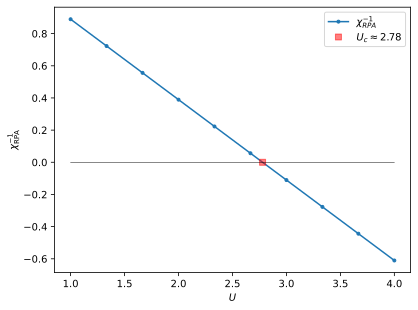

In [4]:
# Write your code here

k_AF = (np.pi, np.pi, 0)
U_vec = np.linspace(1, 4, 10)

U_c = 2 / np.squeeze(chi0_wk(0, k_AF)).real
chi_inv_vec = [ np.squeeze(1/solve_rpa_PH(chi0_wk, U/2 * I)(0, k_AF).real) for U in U_vec ]

plt.plot(U_vec, chi_inv_vec, '.-', label=r'$\chi_{RPA}^{-1}$')
plt.plot(U_c, 0, 'rs', label=r'$U_c \approx %2.2f$'%U_c, alpha=0.5) # a red point at the analytic solution
plt.plot(U_vec, 0 * U_vec, 'k', lw=0.5)

plt.xlabel(r'$U$'); plt.ylabel(r'$\chi_\mathrm{RPA}^{-1}$'); plt.legend();

**Questions**

- What symmetry broken phase do you think the system has a phase transition to at $U_c$?
- What does the Mermin Wagner theorem say about the phase transition?
- How does the RPA approximation compare with the exact result?